In [9]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.common import *


def get_isentropic_check(directory,inp,flist,y): #flist is isentropic_check
    mat = np.zeros([len(flist),5])

    for i,fname in enumerate(flist):
        tID = fname.split('_')[-1]
        tID = int(tID.split('.dat')[0])
        time = nml.read_time(directory,tID)

        # Get y lengthscale and corresponding idx
        dat = np.fromfile(fname,sep=' ')
        #plt.plot(cbar)
        mat[i,0] = time
        mat[i,1] = dat
        
    isort = np.argsort(mat[:,0]) #sort time
    return mat[isort,:]

directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/'
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
x = np.linspace(0,Lx,Nx)
z = np.linspace(0,Lz,Nz)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

# And read growth rates
tlist,dlist,rates = growth_rates(directory+'shearlayer_')

dir_out = directory.split('/projects/ShockInducedMix/')[-1]
dir_out = '/home/kmatsuno/' + dir_out + '/'
print(dir_out)
flist = glob.glob(dir_out+"isentropic*")
flist.sort()
print([f.split('/')[-1] for f in flist])


Params for this run:
	Mc = 2.0
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 80.0x80.0x40.0
/home/kmatsuno/ShearLayerData/production/Mc20/rr1/1024x1448x512//
['isentropic_check_0001.dat', 'isentropic_check_0002.dat', 'isentropic_check_0003.dat', 'isentropic_check_0004.dat', 'isentropic_check_0005.dat', 'isentropic_check_0006.dat', 'isentropic_check_0007.dat', 'isentropic_check_0008.dat', 'isentropic_check_0009.dat', 'isentropic_check_0010.dat', 'isentropic_check_0011.dat', 'isentropic_check_0012.dat', 'isentropic_check_0013.dat']


/home/kmatsuno/ShearLayerData/production/Mc20/rr1/1024x1448x512/isentropic_check_0001.dat
/home/kmatsuno/ShearLayerData/production/Mc20/rr1/1024x1448x512/isentropic_check_0002.dat
/home/kmatsuno/ShearLayerData/production/Mc20/rr1/1024x1448x512/isentropic_check_0003.dat
/home/kmatsuno/ShearLayerData/production/Mc20/rr1/1024x1448x512/isentropic_check_0004.dat
/home/kmatsuno/ShearLayerData/production/Mc20/rr1/1024x1448x512/isentropic_check_0005.dat
/home/kmatsuno/ShearLayerData/production/Mc20/rr1/1024x1448x512/isentropic_check_0006.dat
/home/kmatsuno/ShearLayerData/production/Mc20/rr1/1024x1448x512/isentropic_check_0007.dat
/home/kmatsuno/ShearLayerData/production/Mc20/rr1/1024x1448x512/isentropic_check_0008.dat
/home/kmatsuno/ShearLayerData/production/Mc20/rr1/1024x1448x512/isentropic_check_0009.dat
/home/kmatsuno/ShearLayerData/production/Mc20/rr1/1024x1448x512/isentropic_check_0010.dat


(-10, 10)

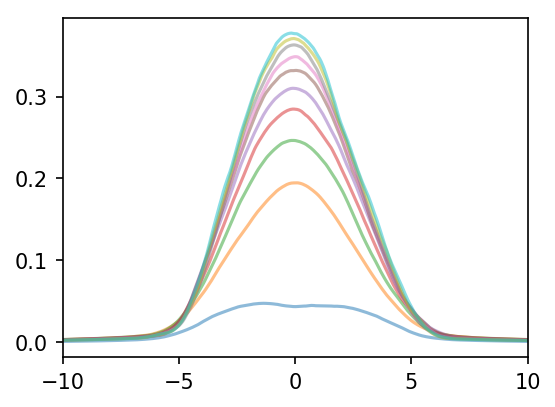

In [10]:
flist = glob.glob(dir_out+"isentropic*")

fig=plt.figure(figsize=(4,3),dpi=150)

for i,fname in enumerate(flist[0:-3]):
    print(fname)
    dat = np.fromfile(fname,sep=' ')
    plt.plot(y/dlist[i],dat,'-',alpha=0.5)
plt.xlim([-10,10])